# Extended GPFA example

In this example, we apply GPFA to neural data of reaching monkeys from [Even-Chen et al. (2019)](https://doi.org/10.1371/journal.pcbi.1006808), as available from the [DANDI Archive](https://doi.org/10.48324/dandi.000121/0.220124.2156). In order to run this example, please download the two `sub-JenkindsC_ses-2016*.nwb` files from the `sub-JenkinsC` folder of the archive and place them in a local directory.

The data originates from recordings of motor cortex area M1 and dorsal pre-motor cortex of monkey J performing the 3-ring task, with the following details:

* The task was a center-out reaching task with 48 targets arranged in three concentric rings of 4, 8, and 12 cm radius, with 16 targets each.
* The monkey had to fitst hold a center target after which a target appeared randomly in one of the 48 locations. After a delay period (uniformly random from 300 to 700 ms), the target's color changed, and the monkey had to reach to the target's location and hold it for 500 ms.
* The neural activity in the dorsal premotor cortex (PMd) and primary motor cortex (M1) was recorded using a 96-electrode array.
* Even-Chen et al. (2019) combined data across four sessions (7722 trials) for analysis, wereas the below example only uses two of these sessions.
* For a comprehensive analysis of the data, please consult [Even-Chen et al. (2019)](https://doi.org/10.1371/journal.pcbi.1006808).

The code in this example requires some additional libraries installed (here listed with the tested version):

* pandas (2.2.2)
* pynwb (2.8.1)
* tqdm (4.65.0)
* matplotlib (3.9.2)

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import pynwb

In [2]:
# include root path to access gpfa module
import sys
import os
sys.path.insert(0, os.path.abspath('../'))

## Loading and pre-processing data
Let us preprocess the spike data from two NWB files. We will first load the raw data, process the trial metadata to extract per-trial condition information and only consider successful trials, and finally assign recorded spike times to individual trials.

In [3]:
nwbfile1_path = 'sub-JenkinsC_ses-20160127T110630_behavior+ecephys.nwb'
nwbfile2_path = 'sub-JenkinsC_ses-20160128T160749_behavior+ecephys.nwb'

In [5]:
nwbfile1 = pynwb.NWBHDF5IO(nwbfile1_path, mode='r').read()
nwbfile2 = pynwb.NWBHDF5IO(nwbfile2_path, mode='r').read()

/Users/jdrugo/HMS Dropbox/Jan Drugowitsch/proj/201908-u19_dsc/src/GPFA_for_sklearn/venv/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/jdrugo/HMS Dropbox/Jan Drugowitsch/proj/201908-u19_dsc/src/GPFA_for_sklearn/venv/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [6]:
def augment_trial_data(trial_df):
    # filter out unsuccessful trials, and trials in which go cue follows target onset within 10ms
    trial_df = trial_df[
        (trial_df['is_successful'] == 1) &
        (trial_df['go_cue_time'] - trial_df['target_shown_time'] > 0.01)]
    # drop unneeded columns
    trial_df.drop(
        ['is_successful', 'task_id', 'version_id', 'reach_time', 'fail_time', 'target_size',
         'barrier_points', 'timeseries'], axis=1, inplace=True)
    # compute target angle (deg) and distance
    def target_pos_to_ang(target_pos):
        return np.rad2deg(np.arctan2(target_pos[0], target_pos[1])).round(1) % 360
    trial_df['target_ang'] = trial_df.apply(
        lambda row: target_pos_to_ang(row.target_pos), axis=1)
    trial_df['target_dist'] = trial_df.apply(
        lambda row: np.linalg.norm(row.target_pos[:2]).round(1), axis=1)
    # reset index
    trial_df.reset_index(drop=True, inplace=True)
    return trial_df

def add_spike_times(trial_df, pop_spike_times):
    # extracting population spikes for each trial, aligned to trial start
    def trial_spike_times(pop_spike_times, start_time, end_time):
        return [spike_times[(spike_times >= start_time) & (spike_times <= end_time)] - start_time
                for spike_times in pop_spike_times]
    tqdm.pandas(desc="Assigning spikes to trials")
    trial_df['spike_times'] = trial_df.progress_apply(
        lambda row: trial_spike_times(pop_spike_times, row.start_time, row.stop_time), axis=1)
    return trial_df

In [7]:
# process per-trial data from both files and concatenate
nwbfiles = [nwbfile1, nwbfile2]
trial_df = [add_spike_times(augment_trial_data(nwbfile.trials.to_dataframe()),
                            nwbfile.units['spike_times'])
            for nwbfile in nwbfiles]
trial_df = pd.concat(trial_df, ignore_index=True)

Assigning spikes to trials: 100%|███████████| 2714/2714 [02:25<00:00, 18.61it/s]


Now let us identify the minimum number of trials available per target angle (ignoring difference in target distance), and the number of simultaneously recorded neurons:

In [8]:
# ensure that we have the same number of trials for each target angle
min_ang_trials = trial_df['target_ang'].value_counts().nsmallest(1).values[0]
trial_df = trial_df.groupby('target_ang').head(min_ang_trials)

n_target_angs = len(trial_df['target_ang'].unique())
n_neurons = len(trial_df.loc[0, 'spike_times'])

print(f'Number of reaching angles: {n_target_angs}')
print(f'Number of trials per reaching angle: {min_ang_trials}')
print(f'Number of neurons: {n_neurons}')

Number of reaching angles: 16
Number of trials per reaching angle: 271
Number of neurons: 192


Next, we turn spike times into (square root) spike counts within individual bins, with a 50 ms bin size. We do so by creating a transformer pipeline that first applies `EventTimesToCount` and then applies a `FunctionTransformer`. We here use the square root transform as a variance-stabilizing transformation to make the (presumably) Poisson spike counts closer to Gaussian, in order to match the assumptions underlying GPFA. Please consult [Yu et al. (2007)](https://doi.org/10.1152/jn.90941.2008) for more details.

In [9]:
from gpfa import EventTimesToCounts
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

bin_size = 0.05

# create transformer pipeline that first bins spike times and then takes the sqrt
spike_binner = make_pipeline(
    EventTimesToCounts(bin_size, extrapolate_last_bin=True),
    FunctionTransformer(np.sqrt))

# apply pipeline to get sqrt binned spike counts for each trial
spike_counts = [spike_binner.transform(spike_times)
                for spike_times in tqdm(trial_df['spike_times'],
                                        desc="Computing binned counts")]

Computing binned counts: 100%|█████████████| 4336/4336 [00:08<00:00, 519.84it/s]


In [10]:
# drop any inactive neurons (identified by summed spike count = 0)
drop_idx = np.where(np.hstack(spike_counts).sum(axis=1) == 0.0)[0]
spike_counts = [np.delete(sci, drop_idx, axis=0) for sci in spike_counts]

# ensure that this matches the rank of the data covariance
cov_rank = np.linalg.matrix_rank(np.cov(np.hstack(spike_counts)))

print(f'Number of active neurons: {spike_counts[0].shape[0]}')
print(f'Rank of training data: {cov_rank}')

Number of active neurons: 192
Rank of training data: 192


When splitting the data into train and test set we need to ensure that we have roughly the same distribution of target angles in both. We achieve this by using `StratifiedShuffleSplit` from `sklearn`.

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

# use stratified split to ensure roughly the same distribution of target angles
ss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
itrain, itest = next(ss.split(spike_counts, trial_df['target_ang']))

# assemble spike counts and associated trial data
X_train = [spike_counts[i] for i in itrain]
X_test = [spike_counts[i] for i in itest]
trial_df_train = trial_df.iloc[itrain]
trial_df_test = trial_df.iloc[itest]

print(f'Number of training trials: {len(X_train)}')
print(f'Number of testing trials: {len(X_test)}')

Number of training trials: 3468
Number of testing trials: 868


## Fitting GPFA and assessing explained variance
Now that have completed data pre-processing, let us fit GPFA with 48 latent dimensions. As this takes a while, it is recommended to save the fitted GPFA instance for later re-use.

In [29]:
from gpfa import GPFA
import pickle

def load_or_fit_gpfa(X_train, gpfa_params, gpfa_filename):
    try:
        with open(gpfa_filename, 'rb') as f:
            gpfa = pickle.load(f)
        print(f'Loaded GPFA instance from {gpfa_filename}')
    except FileNotFoundError:
        gpfa = None

    if not gpfa:
        # Initialize & fit GPFA
        gpfa = GPFA(**gpfa_params)
        gpfa.fit(X_train)

        with open(gpfa_filename, 'wb') as f:
            pickle.dump(gpfa, f, protocol=5)
        print(f'Saved trained GPFA instance to {gpfa_filename}')  

    return gpfa

In [14]:
n_latents = 48  # number of latent states
gpfa_params = {
    'bin_size': bin_size,
    'z_dim': n_latents,
    'verbose': True
}
gpfa = load_or_fit_gpfa(X_train, gpfa_params, f'gpfa_trained_z{n_latents}.pkl')

Loaded GPFA instance from gpfa_trained_z48.pkl


We can now check how much of the training and test set variance GPFA is able to explain. This tells us the overall variance explained, as well as how each latent dimension contributes to this. Please note that there is no guarantee to get the exact same numbers across different machines. This is due to differences in the numberical libraries used by `numpy` for different machine types.

In [15]:
variance_explained_train = gpfa.variance_explained()
print(f"Variance Explained on Training Set: \n{variance_explained_train}")

Variance Explained on Training Set: 
(0.3992009393910759, array([0.17351835, 0.05615378, 0.02239798, 0.01748232, 0.01446882,
       0.01039824, 0.00914995, 0.00724696, 0.00685846, 0.00646204,
       0.0056797 , 0.00492629, 0.00473943, 0.00450233, 0.00414029,
       0.00328787, 0.00323252, 0.00297826, 0.00287856, 0.00256626,
       0.00236071, 0.00215377, 0.00201278, 0.0020225 , 0.00195669,
       0.00183295, 0.0017263 , 0.00161902, 0.00150558, 0.00149001,
       0.00140961, 0.00135689, 0.00129945, 0.00123116, 0.00121173,
       0.00115335, 0.00109072, 0.00103825, 0.00097591, 0.00092354,
       0.00090153, 0.00086231, 0.00083943, 0.0008102 , 0.00073601,
       0.00063187, 0.00058149, 0.00039879]))


In [16]:
variance_explained_test = gpfa.variance_explained(X_test)
print(f"Variance Explained on Test Set: \n{variance_explained_test}")

Variance Explained on Test Set: 
(0.3954474229364759, array([0.17014989, 0.05601392, 0.02228761, 0.01790285, 0.01447102,
       0.01046831, 0.00896038, 0.00730865, 0.00689612, 0.00643297,
       0.00579021, 0.00490258, 0.00471147, 0.00454983, 0.00409858,
       0.00321911, 0.00324409, 0.00300759, 0.00282326, 0.00251672,
       0.00233192, 0.0021585 , 0.0020584 , 0.00201882, 0.00193773,
       0.00180535, 0.00173831, 0.00162533, 0.00145403, 0.00147293,
       0.00136991, 0.00134994, 0.0012836 , 0.00119666, 0.00116035,
       0.00111355, 0.00112453, 0.00099734, 0.00095093, 0.00091606,
       0.00089995, 0.00082632, 0.00082925, 0.00080077, 0.00071533,
       0.00058649, 0.00057132, 0.00039864]))


As can be seen, the variance explained is very similar across training and test set, indicating minimal (if any) overfitting.

## Plotting latent trajectories

We will now inspect inferred (orthogonalized) latent trajectories by plotting them in different ways. For this we will focus on the test set, for which we can get the latent trajectory predictions by calling `gpfa.predict(.)`.

In [17]:
outs, ll = gpfa.predict(returned_data=['Z_mu', 'Z_mu_orth'])
Z_mu_orth = outs['Z_mu_orth']

max_bins = np.max([Zi.shape[1] for Zi in Z_mu_orth])
ts = np.arange(max_bins) * bin_size

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plot_latents = 6
plot_cols = 3
plot_rows = 1 + (plot_latents - 1) // plot_cols
plot_figsize = (19, 8)
plot_same_yscale = False
target_angs = trial_df_train.target_ang.unique()
n_target_angs = len(target_angs)
ts = np.arange(max_bins) * bin_size

As a starting point, let us plot the latent trajectories for the first six latent dimensions for each target angle separately, while averaging across all trials with the same target angle.

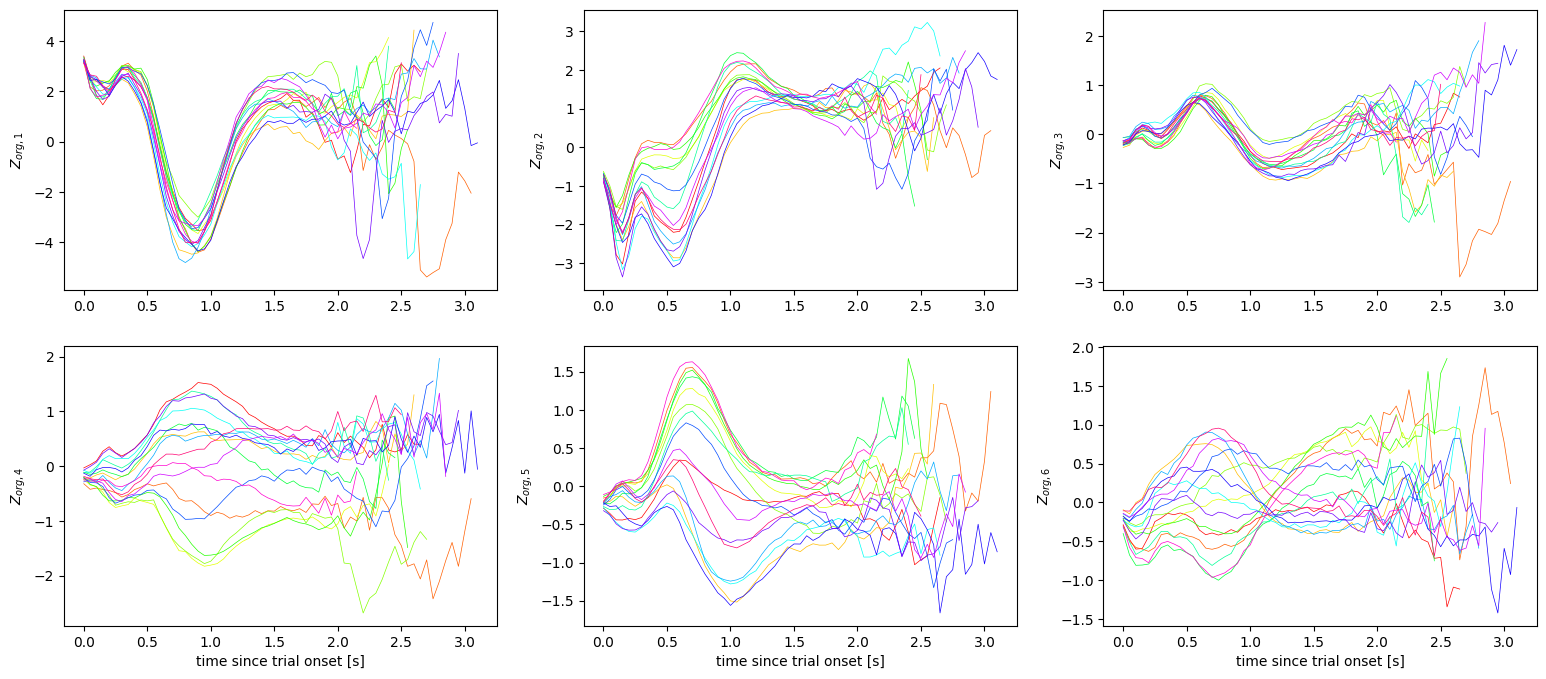

In [19]:
def avg_count(X):
    """Computes the average across different-length sequences in X."""
    max_bins = np.max([Xi.shape[1] for Xi in X])
    X_sum = np.zeros((X[0].shape[0], max_bins))
    X_count = np.zeros_like(X_sum, dtype=int)
    for Xi in X:
        X_sum[:,:Xi.shape[1]] += Xi
        X_count[:,:Xi.shape[1]] += 1
    return X_sum / X_count

# compute across-trial averages
Z_mu_orth_avg = []
for ang_idx in range(n_target_angs):
    ang_trial_idcs = np.flatnonzero(trial_df_train.target_ang == target_angs[ang_idx])
    Z_mu_orth_avg.append(avg_count(Z_mu_orth[ang_trial_idcs]))

# plot them
fig = plt.figure(figsize=plot_figsize)
axs = fig.subplots(plot_rows, plot_cols, sharey=plot_same_yscale)
cmap = mpl.colormaps['hsv']
for latent_idx in range(plot_latents):
    i, j = latent_idx // plot_cols, latent_idx % plot_cols
    for ang_idx in range(n_target_angs):
        ang_col = cmap(ang_idx / n_target_angs)
        axs[i, j].plot(ts[:Z_mu_orth_avg[ang_idx].shape[1]], Z_mu_orth_avg[ang_idx][latent_idx,:], lw=0.5, c=ang_col)
    axs[i, j].set_ylabel(f'$Z_{{org,{latent_idx+1} }}$')
    if i+1 == plot_rows:
        axs[i, j].set_xlabel('time since trial onset [s]')

As can be seen in the above, the first and third dimension seems to be mostly shared across different target angles, whereas the difference in target angle becomes apparent in the second, fourth, fifth, and sixth dimension. The different scales of the vertical axes reflect the different amounts of variance explained by the different dimensions. To visualize this more explicitly, set `plot_same_yscale = True` and replot the above.

The (horizontal) time axis in the above plots is aligned to trial onset ($t=0$), which is when the monkey starts holding the central target. As this is followed by a stochastic delay period, the plots _are not_ aligned by the time that the monkey initiates a reach to the cues target. Let us now instead plot the same average trajectories, but this aligned by the time of the go cue.

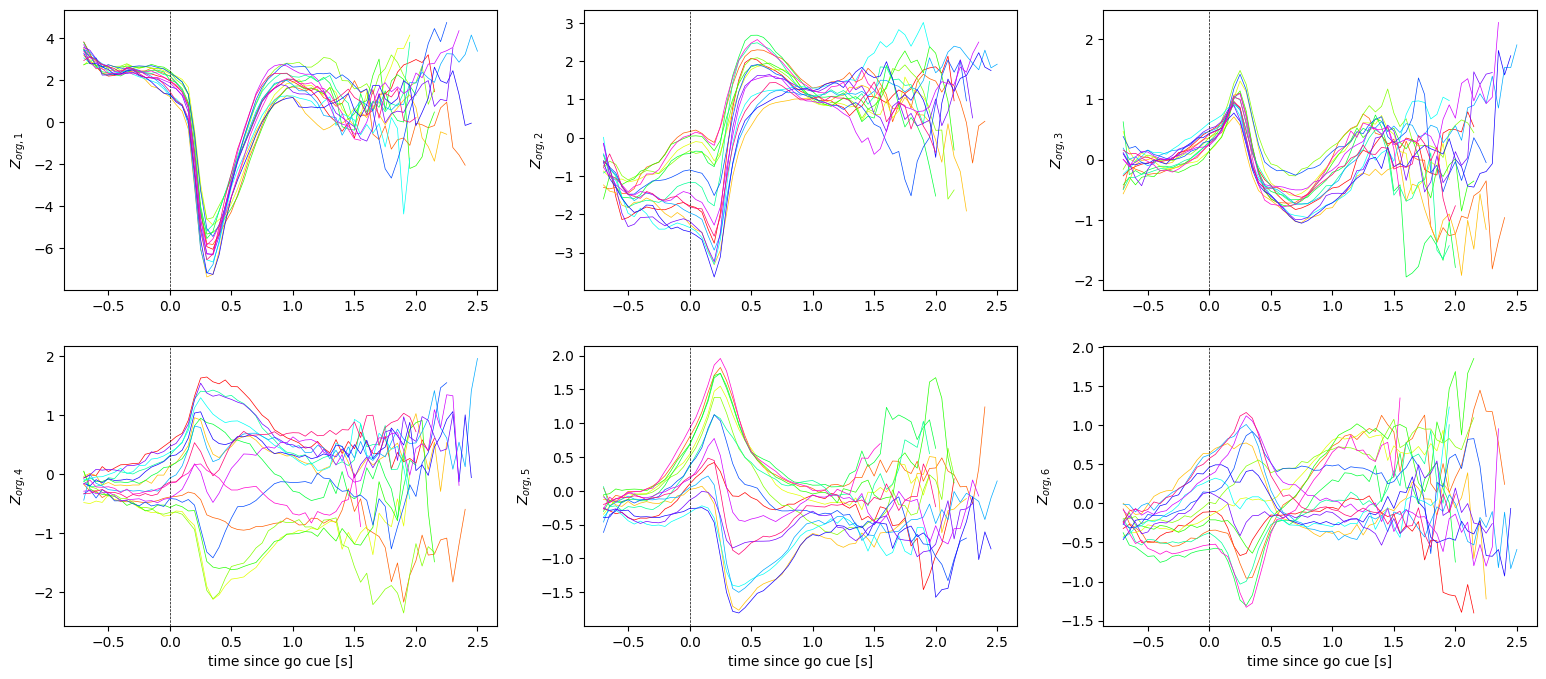

In [20]:
def avg_count_shifted(X, shift):
    """Computes the average across different-length, differently shifted, sequences in X."""
    min_shift = np.min(shift)
    max_bins = np.max([(Xi.shape[1] + shifti - min_shift) for Xi, shifti in zip(X, shift)])
    X_sum = np.zeros((X[0].shape[0], max_bins))
    X_count = np.zeros_like(X_sum, dtype=int)
    for Xi, shifti in zip(X, shift):
        X_sum[:,(shifti - min_shift):(Xi.shape[1] + shifti - min_shift)] += Xi
        X_count[:,(shifti - min_shift):(Xi.shape[1] + shifti - min_shift)] += 1
    return X_sum / X_count, min_shift

# compute across-trial averages
go_cue_shifts = -((trial_df_train.go_cue_time - trial_df_train.start_time) // bin_size).to_numpy().astype(int)
Z_mu_orth_avg = []
Z_shift = []
for ang_idx in range(n_target_angs):
    ang_trial_idcs = np.flatnonzero(trial_df_train.target_ang == target_angs[ang_idx])
    Z_mu_orth_avg_i, Z_shift_i = avg_count_shifted(Z_mu_orth[ang_trial_idcs], go_cue_shifts[ang_trial_idcs])
    Z_mu_orth_avg.append(Z_mu_orth_avg_i)
    Z_shift.append(Z_shift_i)

# plot them
fig = plt.figure(figsize=plot_figsize)
axs = fig.subplots(plot_rows, plot_cols, sharey=plot_same_yscale)
cmap = mpl.colormaps['hsv']
for latent_idx in range(plot_latents):
    i, j = latent_idx // plot_cols, latent_idx % plot_cols
    for ang_idx in range(n_target_angs):
        ang_col = cmap(ang_idx / n_target_angs)
        ang_ts = (np.arange(Z_mu_orth_avg[ang_idx].shape[1]) + Z_shift[ang_idx]) * bin_size
        axs[i, j].plot(ang_ts, Z_mu_orth_avg[ang_idx][latent_idx,:], lw=0.5, c=ang_col)
    axs[i, j].axvline([0], lw=0.5, ls='--', c='black')
    axs[i, j].set_ylabel(f'$Z_{{org,{latent_idx+1} }}$')
    if i+1 == plot_rows:
        axs[i, j].set_xlabel('time since go cue [s]')

These plots paint the same overall picture as before, again showing that the first and third dimension is not modulated by target angle. However, for the remaining dimensions, aligning the latent trajectories by go cue ($t=0$) makes the modulation by target angle more pronounced.

Let us now look at individual trials for a single target angle. We can again do so aligned to either trial onset or go cue. Here, the red dots indicate the time of the go cue.

In [21]:
plot_ang_idx = 0
examples_per_ang = 10
go_cue_bin = ((trial_df_train.go_cue_time - trial_df_train.start_time) // bin_size).to_numpy().astype(int)

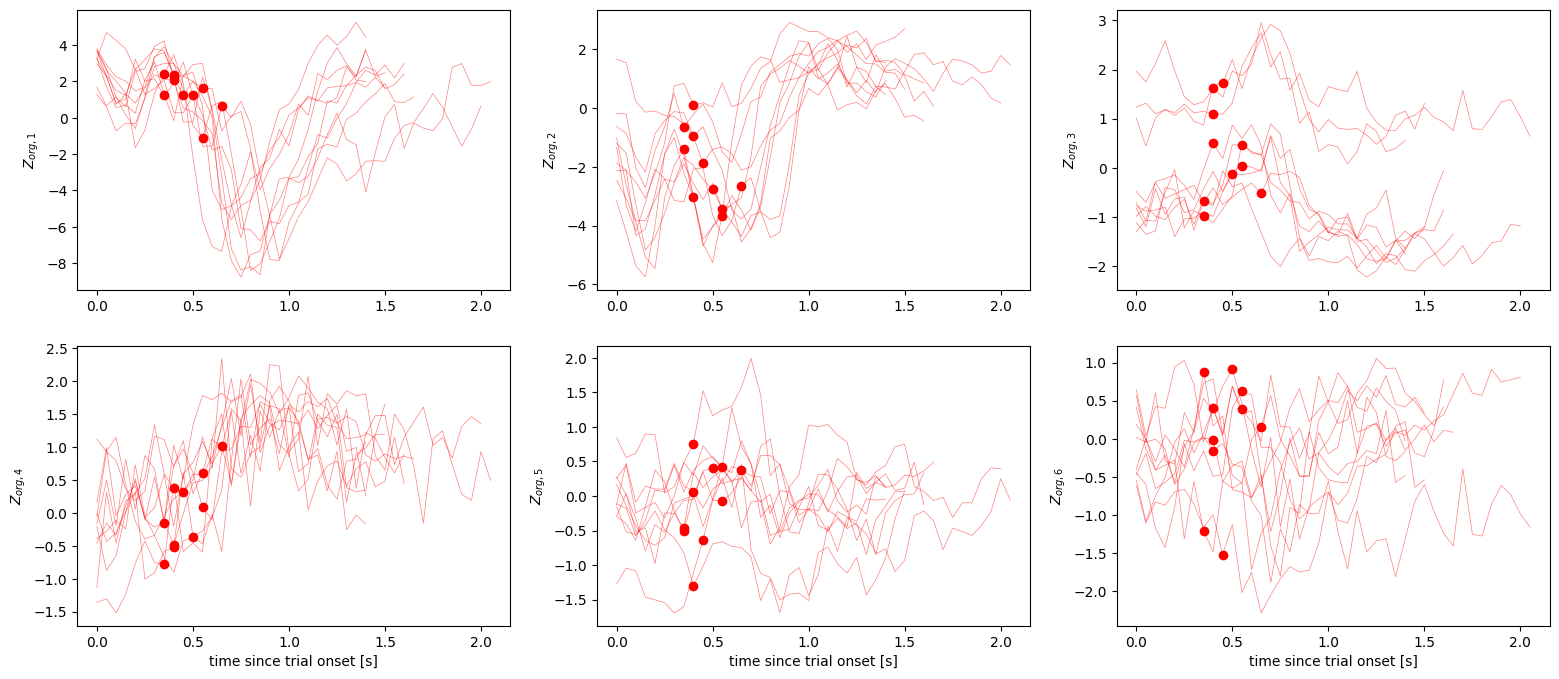

In [22]:
fig = plt.figure(figsize=plot_figsize)
axs = fig.subplots(plot_rows, plot_cols, sharey=plot_same_yscale)
cmap = mpl.colormaps['hsv']
ang_col = cmap(plot_ang_idx / n_target_angs)
ang_trial_idcs = np.flatnonzero(trial_df_train.target_ang == target_angs[plot_ang_idx])
for latent_idx in range(plot_latents):
    i, j = latent_idx // plot_cols, latent_idx % plot_cols
    for trial_idx in ang_trial_idcs[:examples_per_ang]:
        axs[i, j].plot(ts[:Z_mu_orth[trial_idx].shape[1]], Z_mu_orth[trial_idx][latent_idx,:], lw=0.5, c=ang_col, alpha=0.5)
        axs[i, j].plot(ts[go_cue_bin[trial_idx]], Z_mu_orth[trial_idx][latent_idx, go_cue_bin[trial_idx]], 'o', c=ang_col)

    axs[i, j].set_ylabel(f'$Z_{{org,{latent_idx+1} }}$')
    if i+1 == plot_rows:
        axs[i, j].set_xlabel('time since trial onset [s]')

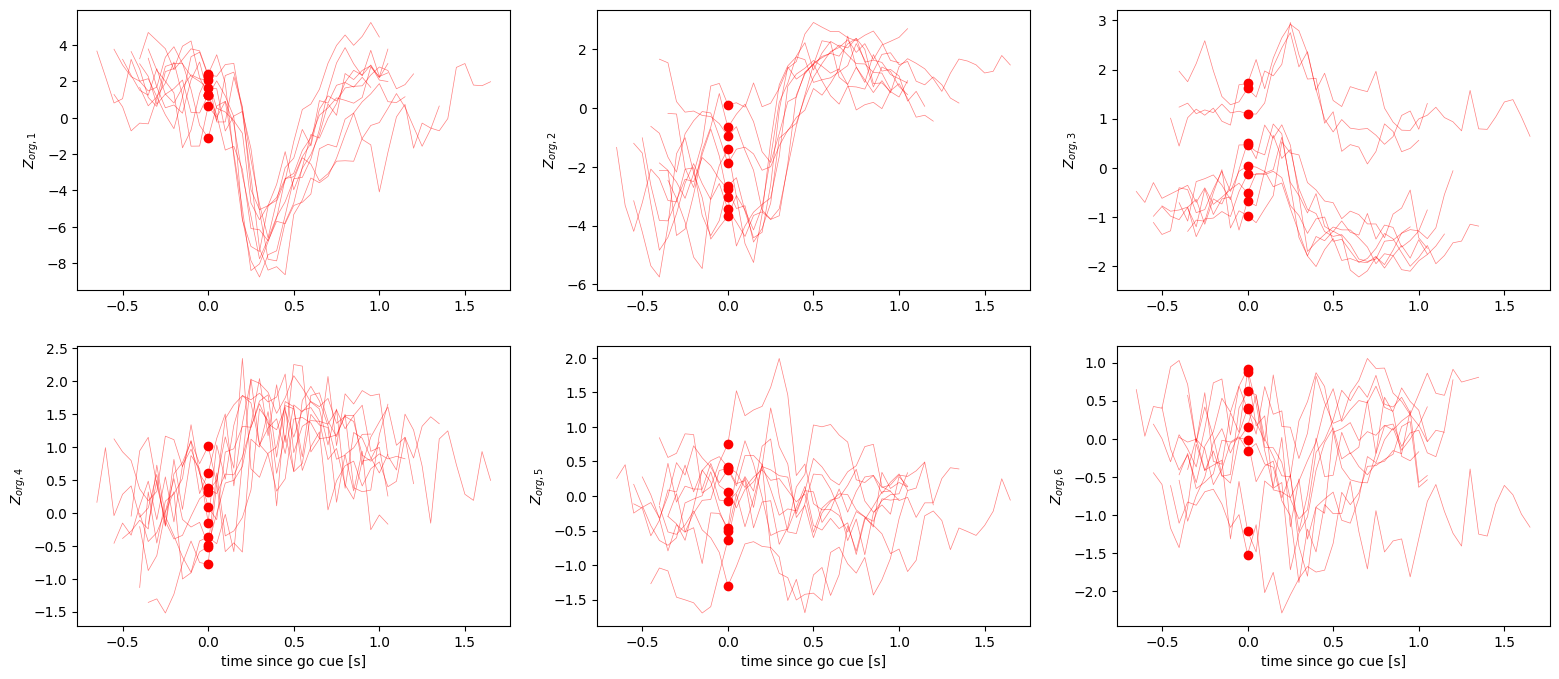

In [23]:
fig = plt.figure(figsize=plot_figsize)
axs = fig.subplots(plot_rows, plot_cols, sharey=plot_same_yscale)
cmap = mpl.colormaps['hsv']
ang_col = cmap(plot_ang_idx / n_target_angs)
ang_trial_idcs = np.flatnonzero(trial_df_train.target_ang == target_angs[plot_ang_idx])
for latent_idx in range(plot_latents):
    i, j = latent_idx // plot_cols, latent_idx % plot_cols
    for trial_idx in ang_trial_idcs[:examples_per_ang]:
        axs[i, j].plot(ts[:Z_mu_orth[trial_idx].shape[1]] - ts[go_cue_bin[trial_idx]], Z_mu_orth[trial_idx][latent_idx,:], lw=0.5, c=ang_col, alpha=0.5)
        axs[i, j].plot(ts[go_cue_bin[trial_idx]] - ts[go_cue_bin[trial_idx]], Z_mu_orth[trial_idx][latent_idx, go_cue_bin[trial_idx]], 'o', c=ang_col)

    axs[i, j].set_ylabel(f'$Z_{{org,{latent_idx+1} }}$')
    if i+1 == plot_rows:
        axs[i, j].set_xlabel('time since go cue [s]')

As can be seen, aligning the trials by go cue again leads to higher coherence in the inferred latent trajectories, even for the same target angle. This suggests that neural activity is organized around onset of the target reaches.

## Tuning more GPFA kernel parameters

So far we used the standard GPFA kernels, which are weighted sums of RBF and white kernels, and where the only parameters that are being learned are the length scales of the RBF kernel per latent dimension. Let us now demonstrate the use of a slightly more flexible kernel that additionally learns the noise level of the white kernels.

In [24]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel

n_latents = 48

# per-latent kernel with adjustable RBF length scale and white noise level
multi_param_kernel = \
    ConstantKernel(1-0.001, constant_value_bounds='fixed') * RBF(length_scale=0.1) + \
    ConstantKernel(0.001, constant_value_bounds='fixed') * WhiteKernel(noise_level=1.0)
gpfa_params = {
    'bin_size': bin_size,
    'z_dim': n_latents,
    'gp_kernel': multi_param_kernel,
    'verbose': True
}
gpfa = load_or_fit_gpfa(X_train, gpfa_params, f'gpfa_wnoise_trained_z{n_latents}.pkl')

Loaded GPFA instance from gpfa_wnoise_trained_z48.pkl


Let's check if the additional degrees of freedom led to more variance explained.

In [25]:
variance_explained_train = gpfa.variance_explained()
print(f"Variance Explained on Training Set: \n{variance_explained_train}")
variance_explained_test = gpfa.variance_explained(X_test)
print(f"Variance Explained on Test Set: \n{variance_explained_test}")

Variance Explained on Training Set: 
(0.39963707534475656, array([0.1737968 , 0.0561864 , 0.02239891, 0.01750683, 0.0145595 ,
       0.01046651, 0.0091139 , 0.00729327, 0.00680928, 0.00636222,
       0.00567846, 0.00500113, 0.00470728, 0.00459619, 0.0041461 ,
       0.00329082, 0.00324429, 0.0029161 , 0.00291704, 0.00262932,
       0.0023265 , 0.00200829, 0.00209952, 0.00201237, 0.00177465,
       0.00187618, 0.00165613, 0.0016431 , 0.00154269, 0.00149257,
       0.00139692, 0.00140225, 0.00127178, 0.00120969, 0.00118104,
       0.00111541, 0.00105646, 0.00102362, 0.00095981, 0.00095175,
       0.00091618, 0.00086237, 0.00086983, 0.00080678, 0.00071403,
       0.00065831, 0.00067484, 0.00051366]))
Variance Explained on Test Set: 
(0.3958741644508559, array([0.17044693, 0.05606366, 0.02230397, 0.01792852, 0.01458266,
       0.01051524, 0.00894158, 0.0073336 , 0.00680272, 0.00635707,
       0.00579198, 0.00498784, 0.00470922, 0.004619  , 0.00411608,
       0.00321078, 0.00328978, 0.00288

We see a minor increase in the variance explained for the training set, but the variance explained for the test set remains practially unchanged. Thus, the mild increase in the adjustable GP kernel parameters did not substantially increase the fit quality in this example.

Note that this does not imply that using different GPFA kernels would not lead to better fits, or that the same fitting applied to different data does not improve the fit.

## Determining the best latent space dimensionality

So far we fixed the dimensionality of the latent space to 48. Let us now ask how to best tune the number of dimensions. For this we fit multiple GPFA models with different latent space dimensionality to the data, and then compare their fit quality. Note that this might take a very long time.

In [30]:
cv_folds = 3
test_set_fraction = 0.8
n_latents = [3, 16, 32, 48, 64, 80, 120]

In [31]:
log_likelihoods = np.empty((cv_folds, len(n_latents)))
var_explained_train = np.empty((cv_folds, len(n_latents)))
var_explained_test = np.empty((cv_folds, len(n_latents)))
gpfa_params = {
    'bin_size': bin_size,
    'z_dim': n_latents[0],
    'verbose': True
}

for in_latents, z_dim in enumerate(n_latents):
    # use stratified split to ensure roughly the same distribution of target angles
    ss = StratifiedShuffleSplit(n_splits=cv_folds, train_size=0.8, random_state=42)
    for cv_fold, (itrain, itest) in enumerate(ss.split(spike_counts, trial_df['target_ang'])):
        # assemble train/test spike counts
        X_train = [spike_counts[i] for i in itrain]
        X_test = [spike_counts[i] for i in itest]
        # load or fit gpfa
        gpfa_params['z_dim'] = z_dim
        gpfa = load_or_fit_gpfa(X_train, gpfa_params, f'gpfa_trained_z{z_dim}_cv{cv_fold}.pkl')
        # compute various quality-of-fit metrics
        var_explained_train[cv_fold, in_latents], _ = gpfa.variance_explained()
        var_explained_test[cv_fold, in_latents], _ = gpfa.variance_explained(X_test)
        log_likelihoods[cv_fold, in_latents] = gpfa.score(X_test)

Loaded GPFA instance from gpfa_trained_z3_cv0.pkl
Loaded GPFA instance from gpfa_trained_z3_cv1.pkl
Loaded GPFA instance from gpfa_trained_z3_cv2.pkl
Loaded GPFA instance from gpfa_trained_z16_cv0.pkl
Loaded GPFA instance from gpfa_trained_z16_cv1.pkl
Loaded GPFA instance from gpfa_trained_z16_cv2.pkl
Loaded GPFA instance from gpfa_trained_z32_cv0.pkl
Loaded GPFA instance from gpfa_trained_z32_cv1.pkl
Loaded GPFA instance from gpfa_trained_z32_cv2.pkl
Loaded GPFA instance from gpfa_trained_z48_cv0.pkl
Loaded GPFA instance from gpfa_trained_z48_cv1.pkl
Loaded GPFA instance from gpfa_trained_z48_cv2.pkl
Loaded GPFA instance from gpfa_trained_z64_cv0.pkl
Loaded GPFA instance from gpfa_trained_z64_cv1.pkl
Loaded GPFA instance from gpfa_trained_z64_cv2.pkl
Loaded GPFA instance from gpfa_trained_z80_cv0.pkl
Loaded GPFA instance from gpfa_trained_z80_cv1.pkl
Loaded GPFA instance from gpfa_trained_z80_cv2.pkl
Loaded GPFA instance from gpfa_trained_z120_cv0.pkl
Loaded GPFA instance from gpfa_tr

Let's plot the results. For this we will look both at the log-likelihood, as well as the variance explained.

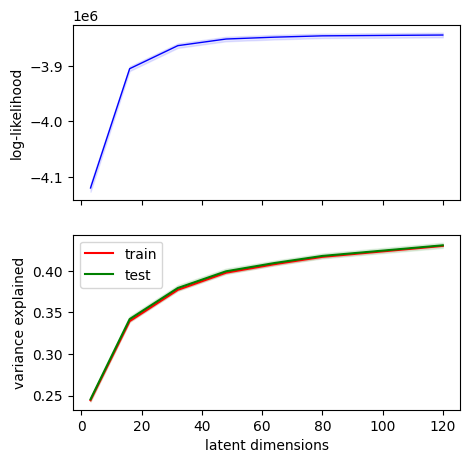

In [33]:
log_likelihoods_mu = np.mean(log_likelihoods, axis=0)
log_likelihoods_sd = np.sqrt(np.var(log_likelihoods, axis=0))
var_explained_train_mu = np.mean(var_explained_train, axis=0)
var_explained_train_sd = np.sqrt(np.var(var_explained_train, axis=0))
var_explained_test_mu = np.mean(var_explained_test, axis=0)
var_explained_test_sd = np.sqrt(np.var(var_explained_test, axis=0))

fig = plt.figure(figsize=(5, 5))
axs = fig.subplots(2, 1, sharex=True)
axs[0].fill_between(n_latents, log_likelihoods_mu + log_likelihoods_sd,
                    log_likelihoods_mu - log_likelihoods_sd, color='blue', alpha=0.1)
axs[0].plot(n_latents, log_likelihoods_mu, c='blue', lw=1)
axs[0].set_ylabel('log-likelihood')

axs[1].fill_between(n_latents, var_explained_train_mu + var_explained_train_sd,
                    var_explained_train_mu - var_explained_train_sd, color='red', alpha=0.1)
axs[1].fill_between(n_latents, var_explained_test_mu + var_explained_test_sd,
                    var_explained_test_mu - var_explained_test_sd, color='green', alpha=0.1)
axs[1].plot(n_latents, var_explained_train_mu, c='red', label='train')
axs[1].plot(n_latents, var_explained_test_mu, c='green', label='test')
axs[1].set_xlabel('latent dimensions')
axs[1].set_ylabel('variance explained')
axs[1].legend()

As can be seen, both the log-likelihood as well as the variance explained monotonically increases with the number of latent dimensions. This indicates that the neural data is intrinsically high-dimensional. We would expect these measures to peak at some higher dimension and the decrease again, but don't see this happen up to 120 dimensions.